In [1]:
#Comparing Scores: Parametric

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/100-resnet_d3_param.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [6]:
!ls $pred_save_dir

01-resnet_baseline.nc	   81.2-resnet_d3_dr_0.1.nc
02-resnet_2dt.nc	   81.3-resnet_d3_dr_0.1.nc
100-resnet_d3_param.nc	   81-resnet_d3_dr_0.1_fixed.nc
105-resnet_d3_dr_0.5.nc    81-resnet_d3_dr_0.1.nc
80.1-resnet_d3_dr_0.05.nc  82.1-resnet_d3_dr_0.2.nc
80-resnet_d3_dr_0.05.nc    82-resnet_d3_dr_0.2.nc
81.1-resnet_d3_dr_0.1.nc   saved_models


In [5]:
preds_parametric=xr.open_dataset(f'{pred_save_dir}/100-resnet_d3_param.nc')
preds_parametric=preds_parametric.rename({'z-mean':'z_mean','z-std':'z_std', 't-mean':'t_mean', 't-std':'t_std'})
preds_parametric

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8722)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_std    (time, lat, lon) float64 ...
    t_std    (time, lat, lon) float64 ...
    z_mean   (time, lat, lon) float64 ...
    t_mean   (time, lat, lon) float64 ...

In [6]:
#Observation
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

observation=observation.astype('float64')
observation=observation.drop('level')

In [7]:
import xskillscore as xs

In [8]:
#Std is wrong in preds_parametric.Subtract mean from it
exp_id_path='/home/garg/WeatherBench/nn_configs/B/100-resnet_d3_param.yml'
args=load_args(exp_id_path)
exp_id=args['exp_id']
    
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
mean_z=mean.isel(level=2).values
mean_t=mean.isel(level=12).values

In [9]:
preds_parametric['z_std']=np.abs(preds_parametric['z_std']-mean_z)
preds_parametric['t_std']=np.abs(preds_parametric['t_std']-mean_t)

In [10]:
preds_parametric_mean=preds_parametric[['z_mean','t_mean']].rename({'z_mean':'z_500','t_mean':'t_850'})
preds_parametric_std=preds_parametric[['z_std','t_std']].rename({'z_std':'z_500','t_std':'t_850'})

In [11]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[None, : , None]).mean(mean_dims)
    return crps

In [12]:
crps=compute_weighted_crps_gaussian(observation.sel(time=preds_parametric.time), 
                                    preds_parametric_mean, preds_parametric_std)

In [13]:
crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 184.0
    t_850    float64 1.109

In [12]:
#RMSE
rmse=compute_weighted_rmse(preds_parametric_mean, observation)

In [13]:
rmse.load()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 414.4
    t_850_rmse  float64 2.236

In [17]:
#COMPARING WITH Ensemble SCORES

In [21]:
exp_id='81-resnet_d3_dr_0.1'
preds_ensemble=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [17]:
crps=compute_weighted_crps_gaussian(observation.sel(time=preds_ensemble.time), 
                                    preds_ensemble.mean('member'), preds_ensemble.std('member'))

In [18]:
crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 160.1
    t_850    float64 1.053

In [19]:
rmse=compute_weighted_rmse(preds_ensemble.mean('member'),observation)

In [20]:
rmse.load()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 317.9
    t_850_rmse  float64 1.837

In [23]:
#Std values are different for parametric and ensemble. Spread-skill ratio
print(preds_parametric_std.z_500.mean().values)
print(preds_ensemble.z_500.std('member').mean().values)

451.21265113957475
130.36804092870207


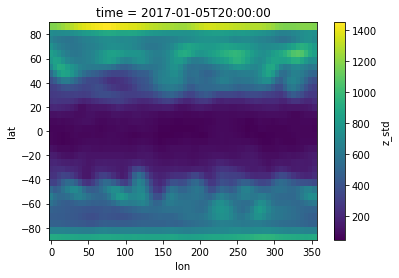

In [21]:
preds_parametric.z_std.isel(time=20).plot() #visual is ok.

### Rank Histogram
ToDo: Too slow for big data.

In [14]:
z_500=xr.DataArray(np.random.normal(preds_parametric.z_mean.values, preds_parametric.z_std.values,
                                    size=[100,8722,32,64]),
                     coords={'member': np.arange(100),
                             'time': preds_parametric.time,
                             'lat': preds_parametric.lat, 'lon': preds_parametric.lon,}, 
                     dims=['member','time','lat', 'lon'])

t_850=xr.DataArray(np.random.normal(preds_parametric.t_mean.values, preds_parametric.t_std.values,
                                    size=[100,8722,32,64]),
                     coords={'member': np.arange(100),
                             'time': preds_parametric.time,
                             'lat': preds_parametric.lat, 'lon': preds_parametric.lon,}, 
                     dims=['member','time','lat', 'lon'])

In [15]:
preds_new=xr.Dataset()
preds_new['z_500']=z_500
preds_new['t_850']=t_850
preds_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 100, time: 8722)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 5.152e+04 5.208e+04 ... 4.919e+04
    t_850    (member, time, lat, lon) float64 253.6 257.5 251.9 ... 254.5 242.9

In [16]:
obs=observation.sel(time=preds_parametric.time)

In [17]:
obs = obs.chunk({'time': 500})
preds_new=preds_new.chunk({'time':500})
#Ques: doesnt help much. still unable to run rank-histogram on full data due to memory error.

In [29]:
#Method 3: Rank Histogram
from ranky import rankz

obs = np.asarray(obs.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.

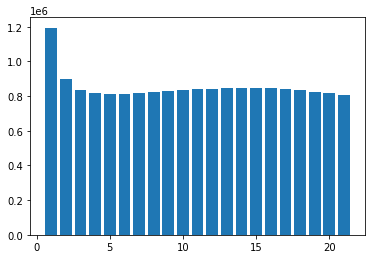

In [30]:
#Taking 100 random points from gaussian and making an ensemble
preds_parametric_small=preds_new.sel(member=slice(0,19))

pred=np.asarray(preds_parametric_small.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show()

In [33]:
obs2=observation.sel(time=preds_ensemble.time)

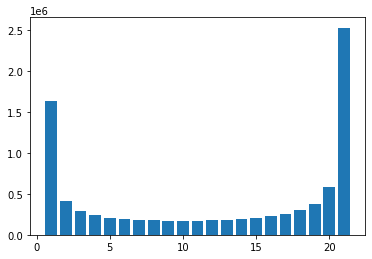

In [34]:
#actual ensemble generated by test-time dropout method

obs = np.asarray(obs2.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
preds_ensemble_small=preds_ensemble.sel(member=slice(0,19))

pred=np.asarray(preds_ensemble_small.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

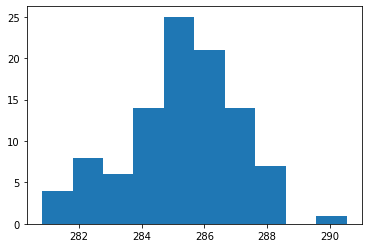

In [37]:
_=plt.hist(preds_new.t_850.isel(lat=20,lon=30,time=2), bins='auto')
plt.show()

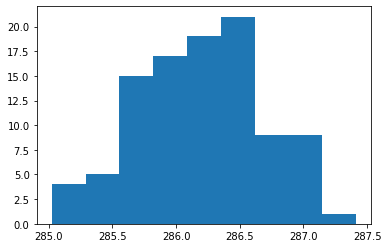

In [38]:
_=plt.hist(preds_ensemble.t_850.isel(lat=20,lon=30,time=2), bins='auto')
plt.show()

In [ ]:
#Spread-SKill

In [22]:
mean_spread = []
mean_error = []
for ds in [preds_new, preds_ensemble]:
    mean_spread.append(compute_weighted_meanspread(ds).load())
    ens_mean = ds.mean('member')
    mean_error.append(compute_weighted_rmse(ens_mean, observation).load())

MemoryError: Unable to allocate 6.63 GiB for an array with shape (100, 4342, 32, 64) and data type float64

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['parametric_ensemble', 'dropout_ensemble'], [ds.z_500_rmse for ds in mean_error])
ax2.bar(['parametric_ensemble', 'dropout_ensemble'], [ds.z_500_mean_spread for ds in mean_spread])
ax3.bar(['parametric_ensemble', 'dropout_ensemble'], [ds1.z_500_mean_spread / ds2.z_500_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

In [25]:
mean_error = compute_weighted_rmse(preds_new, observation).load()

In [20]:
mean_spread = compute_weighted_meanspread(preds_new).load()

In [27]:
#100 samples drawn from parametric. 
    print('rmse:', mean_error.z_500_rmse.values,  mean_error.t_850_rmse.values)
    print('spread:', mean_spread.z_500_mean_spread.values,  mean_spread.t_850_mean_spread.values)
    print('spread-skill:', mean_spread.z_500_mean_spread.values/mean_error.z_500_rmse.values,  
          mean_spread.t_850_mean_spread.values/mean_error.t_850_rmse.values)
    print("")

rmse: 575.9526177548905 3.1455424519742845
spread: 398.0139760658301 2.200959267340533
spread-skill: 0.6910533328545679 0.6997073798699208

